In [1]:
### import numpy as np 
import pandas as pd
import allel
import malariagen_data
import matplotlib.patches as patches
%matplotlib inline
import sys
# adding Folder_2 to the system path
import probe
%run hapclust.py
import locusPocus
import json

In [2]:
def plotGenes(ax, start=28_524_224, stop=28_573_000, contig='2L', labels=False):

    gff3 = ag3.geneset()
    gff3 = gff3.query("start > @start & end < @stop")
    genegff = gff3.query("type == 'gene' & contig == @contig")
    locgff = gff3.query("type == 'exon' & contig == @contig")

    min_= locgff.start.min()
    max_ = locgff.end.max()

    ax.set_xlim(start, stop)
    ax.set_ylim(-0.5, 2)
    ax.axhline(0.5, color='k', linewidth=3)
    ax.set_yticks(ticks=[0.2,1.2], labels=['- ', '+'], size=20)
    ax.tick_params(top=False,
                   bottom=False,
               left=False,
               right=False,
               labelleft=True,
               labelbottom=False)
    #ax.tick_params(axis='x', which='major', labelsize=11)
    ax.set_ylabel("Genes")
    #ax.set_xlabel(f"Chromosome {contig} position", fontdict={'fontsize':14})

    for _, exon in locgff.iterrows():
        start, end = exon[['start', 'end']]
        strand = exon['strand']
        if strand == '+':
            rect = patches.Rectangle((start, 0.55), end-start, 0.3, linewidth=3,
                                edgecolor='none', facecolor="grey", alpha=0.9)
        else:
            rect = patches.Rectangle((start, 0.45), end-start, -0.3, linewidth=3,
                                edgecolor='none', facecolor="grey", alpha=0.9)
        ax.add_patch(rect)

    for _, gene in genegff.iterrows():
        start, end = gene[['start', 'end']]
        size = end-start
        corr = size/4
        strand = gene['strand']
        if strand == '+':
            rect = patches.Rectangle((start, 0.55), end-start, 0.3, linewidth=3,
                                edgecolor='black', facecolor="none")
            if labels == True: ax.text(((start+end)/2)-corr, 0.95, s=gene['ID'], fontdict= {'fontsize':12}, rotation=20)
        else:
            rect = patches.Rectangle((start, 0.45), end-start, -0.3, linewidth=3,
                                edgecolor='black', facecolor="none")
            if labels == True: ax.text(((start+end)/2)-corr,  -0.3, s=gene['ID'], fontdict= {'fontsize':12}) 
        ax.add_patch(rect)
        #rect2 = patches.Rectangle((start, -2), end-start, 4, linewidth=3,
        #                        edgecolor='none', facecolor="gainsboro", zorder=0) #"#f2f2f2"
        #ax.add_patch(rect2)

## Coeae1f region haplotype clustering

In [3]:
ag3 = malariagen_data.Ag3(pre=True)

### Load cohorts

Which populations do we want to look at?

In [4]:
sample_sets = [
    # Ag1000G phase 3 sample sets in Ag3.0
    "AG1000G-GH", 
    'AG1000G-ML-A',
     'AG1000G-BF-A',
     'AG1000G-BF-B',
     'AG1000G-GN-A',
     'AG1000G-GN-B',
    'AG1000G-TZ',
    # Amenta-Etego sample sets in Ag3.3
    # GAARDIAN sample set in Ag3.4
    '1244-VO-GH-YAWSON-VMF00149',
    # GAARD Ghana sample set in Ag3.2
     "1244-VO-GH-YAWSON-VMF00051",
     '1245-VO-CI-CONSTANT-VMF00054',
     '1253-VO-TG-DJOGBENOU-VMF00052',
     '1237-VO-BJ-DJOGBENOU-VMF00050'
]

In [5]:
contig= '2L'
name='coeae1f'

coeae1f_start = 28_545_396
coeae1f_end = 28_547_938
coeae2f_start = 28_548_433
coeae2f_end = 28_550_748

coeregion = '2L:28520000-28580000'

transcript= "AGAP006227-RA"
gene = transcript.replace("-RA", "")

### Load metadata and haplotypes

In [8]:
metaquery = None

ds_haps = ag3.haplotypes(contig, sample_sets=sample_sets, analysis='gamb_colu_arab')
names = ds_haps['sample_id'].values
pos = allel.SortedIndex(ds_haps['variant_position'])

print(metahaps.shape)

AttributeError: 'Dataset' object has no attribute 'shape'

### EHH in sweep clusters 

Designate flanks

In [10]:
import json
with open("../../results/haplotype_clusters.json", 'r') as j:
     cluster_json = json.loads(j.read())

clusters_df = pd.read_csv("../../results/haplotype_clusters_metadata.tsv", sep="\t", index_col=0)
metahaps = pd.read_csv("../../results/haplotype_metahaps.tsv", sep="\t")

bf_colu_wt_inds  = metahaps.query("hap_cluster == 'WT'").query("country == 'Burkina Faso' & taxon == 'coluzzii' & year == 2014").index.values
gn_gamb_wt_inds  = metahaps.query("hap_cluster == 'WT'").query("country == 'Guinea' & taxon == 'gambiae'& year == 2012").index.values
tz_arab_wt_inds  = metahaps.query("hap_cluster == 'WT'").query("country == 'Tanzania' & taxon == 'arabiensis'& year == 2015").index.values

In [11]:
loc_focus = 28548072
flanking = 50_000

def ehh(ds_haps, idxs, name, loc_focus, flank):
    
    pos = allel.SortedIndex(ds_haps['variant_position'].values)
    upstream = pos.locate_ranges([loc_focus-flanking], [loc_focus])
    downstream = pos.locate_ranges([loc_focus], [loc_focus+flanking])
    pos_ehh_region = np.concatenate([pos[upstream], pos[downstream]])
    
    haps_upstream = allel.GenotypeArray(ds_haps.isel(variants=upstream)['call_genotype']).to_haplotypes().take(idxs, axis=1)
    haps_downstream = allel.GenotypeArray(ds_haps.isel(variants=downstream)['call_genotype']).to_haplotypes().take(idxs, axis=1)
    ehh_upstream = allel.ehh_decay(haps_upstream)
    ehh_downstream = allel.ehh_decay(haps_downstream)
    ehh = np.concatenate([ehh_upstream[::-1], ehh_downstream])
    ehh_df = pd.DataFrame({'ehh': ehh, 'group':name, 'pos':pos_ehh_region})

    return(ehh_df)

In [12]:
ehh_dict = {}

# and then same in sweeps 
for k, idxs in cluster_json.items():
    if k == 'WT': continue
        
    ehh_dict[k] = ehh(ds_haps, idxs, k, loc_focus, flanking)
    
ehh_dict["WT_TZ_arab"] = ehh(ds_haps, tz_arab_wt_inds, "WT_TZ_arab", loc_focus, flanking)
ehh_dict['WT_BF_colu'] = ehh(ds_haps, bf_colu_wt_inds, "WT_BF_colu", loc_focus, flanking)
ehh_dict['WT_GN_gamb'] = ehh(ds_haps, gn_gamb_wt_inds, "WT_GN_gamb", loc_focus, flanking)

ehh_df = pd.concat(ehh_dict).reset_index(drop=True)

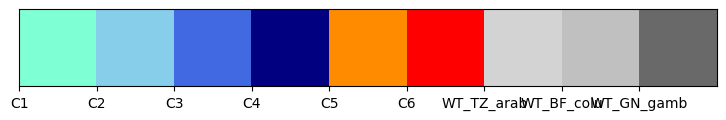

In [13]:
palette = clusters_df['palette'].to_list()
hap_labels = list(ehh_dict.keys())

palette.append(("silver"))
palette.append(("dimgrey"))

sns.palplot(palette)
plt.gca().set_xticklabels(hap_labels);

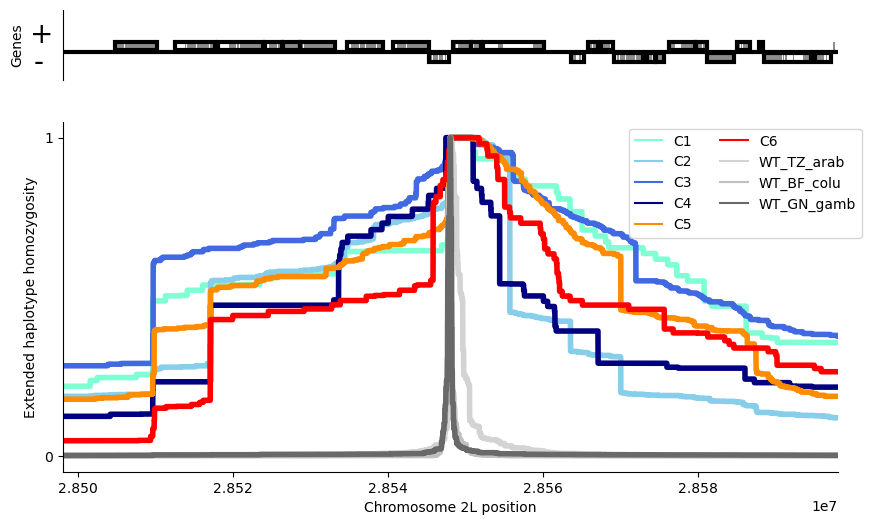

In [14]:
fig, ax = plt.subplots(2,1, figsize=[10,6], gridspec_kw={'height_ratios':[1,5]})
plotGenes(ax=ax[0], start=ehh_df.pos.min(), stop=ehh_df.pos.max(), contig='2L')
sns.despine(ax=ax[0], bottom=True)
sns.despine(ax=ax[1])
sns.lineplot(ax=ax[1], data=ehh_df, x='pos', y='ehh', hue='group', linewidth=4, palette=palette)
ax[1].set_ylabel("Extended haplotype homozygosity")
ax[1].set_xlabel("Chromosome 2L position")
ax[1].set_xlim(loc_focus-flanking, loc_focus+flanking)
ax[1].set_yticks([0,1])
plt.legend(bbox_to_anchor=(1.04,1), loc="best", ncol=2)

## With / without CNV in the CNV containing sweep

In [160]:
cnv_ids = pd.read_csv("../../results/cnv_tz_ids.tsv", sep="\t", index_col=0)

In [157]:
metahaps, q = locusPocus.load_metahaps(sample_sets, names, sample_query=None)
meta_cnv_sweep = metahaps.take(cluster_json['C1'])

In [158]:
meta_cnv_sweep['country'].value_counts()

Tanzania    89
Name: country, dtype: int64

In [161]:
meta_cnv_bool = np.isin(meta_cnv_sweep['sample_id'], cnv_ids)

meta_cnv = meta_cnv_sweep[meta_cnv_bool]
meta_non_cnv = meta_cnv_sweep[~meta_cnv_bool]

In [162]:
meta_cnv.location.value_counts()

Moshi    17
Name: location, dtype: int64

In [169]:
pos = allel.SortedIndex(ds_haps['variant_position'].values)
upstream = pos.locate_ranges([loc_focus-flanking], [loc_focus])
downstream = pos.locate_ranges([loc_focus], [loc_focus+flanking])
pos_ehh_region = np.concatenate([pos[upstream], pos[downstream]])

snps_up_cnv = allel.GenotypeArray(ds_haps.isel(variants=upstream)['call_genotype']).to_haplotypes().take(cluster_json['C1'], axis=1).compress(meta_cnv_bool, axis=1)
snps_down_cnv = allel.GenotypeArray(ds_haps.isel(variants=downstream)['call_genotype']).to_haplotypes().take(cluster_json['C1'], axis=1).compress(meta_cnv_bool, axis=1)
ehh_up_cnv = allel.ehh_decay(snps_up_cnv)
ehh_down_cnv = allel.ehh_decay(snps_down_cnv)
ehh_cnv = np.concatenate([ehh_up_cnv[::-1], ehh_down_cnv])
ehh_cnv = pd.DataFrame({'ehh': ehh_cnv, 'group':'C1_Dup2', 'pos':pos_ehh_region})

snps_up_non_cnv = allel.GenotypeArray(ds_haps.isel(variants=upstream)['call_genotype']).to_haplotypes().take(cluster_json['C1'], axis=1).compress(~meta_cnv_bool, axis=1)
snps_down_non_cnv = allel.GenotypeArray(ds_haps.isel(variants=downstream)['call_genotype']).to_haplotypes().take(cluster_json['C1'], axis=1).compress(~meta_cnv_bool, axis=1)
ehh_up_non_cnv = allel.ehh_decay(snps_up_non_cnv)
ehh_down_non_cnv = allel.ehh_decay(snps_down_non_cnv)
ehh_non_cnv = np.concatenate([ehh_up_non_cnv[::-1], ehh_down_non_cnv])
ehh_non_cnv = pd.DataFrame({'ehh': ehh_non_cnv, 'group':'C1_NoDup', 'pos':pos_ehh_region})


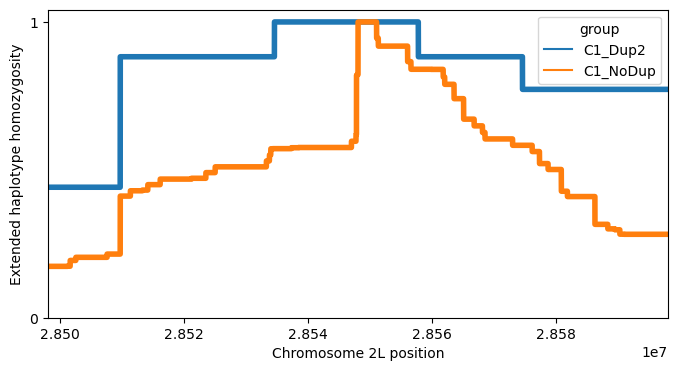

In [177]:
ehh_cnv_df = pd.concat([ehh_cnv, ehh_non_cnv]).reset_index(drop=True)

fig, ax = plt.subplots(1,1, figsize=[8,4])
sns.lineplot(data=ehh_cnv_df, x='pos', y='ehh', hue='group', linewidth=4)
ax.set_ylabel("Extended haplotype homozygosity")
ax.set_xlabel("Chromosome 2L position")
ax.set_xlim(loc_focus-flanking, loc_focus+flanking)
ax.set_yticks([0,1])